In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from math import sqrt
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_x = pd.read_csv("dengue_features_train.csv")
#df_x = df_x.drop('reanalysis_sat_precip_amt_mm',axis=1)
df_y = pd.read_csv("dengue_labels_train.csv")

In [3]:
df_x.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [4]:
df = pd.merge(df_x, df_y,  how='left', left_on=['city','year','weekofyear'],right_on=['city','year','weekofyear'])

In [5]:
df.columns = df.columns.str.replace(r"reanalysis", "re_an")
df.columns = df.columns.str.replace(r"humidity", "hd")
df.columns = df.columns.str.replace(r"precipitation","prec")
df.drop(['weekofyear', 'week_start_date'],1,inplace=True)

In [6]:
df = df.fillna(method='ffill')

threshold_columns = ['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']
for i in threshold_columns:
    df[i][df[i] <= 0.25] = 0
    df[i][df[i] > 0.25] = 1
    df[i] = df[i].astype('category')
    
categoricalFeatureNames = ["city", 'year','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']
for var in categoricalFeatureNames:
    df[var] = df[var].astype("category")

df_y = df['total_cases']
df.drop('total_cases',axis=1,inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df_y, test_size=0.20)

X_train_categorical = X_train[categoricalFeatureNames]
X_test_categorical = X_test[categoricalFeatureNames]

df_train_numeric = X_train.drop(columns=['city', 'year',
                                    'ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw'])


df_test_numeric = X_test.drop(columns=['city', 'year',
                                    'ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw'])

df_train_dummies = pd.get_dummies(X_train_categorical)

df_test_dummies = X_test_categorical.reindex(columns = df_train_dummies.columns, fill_value=0)

In [8]:
scaler = StandardScaler()
standardized_train_numeric_data = scaler.fit_transform(df_train_numeric)
standardized_test_numeric_data = scaler.transform(df_test_numeric)

df_standardized_train  = np.concatenate([standardized_train_numeric_data,np.array(df_train_dummies)],axis=1)
df_standardized_test = np.concatenate([standardized_test_numeric_data,np.array(df_test_dummies)],axis=1)

__Difference of the absolute of observed and predicted error helps in better understand the performance of the model. But this approach will pose an issue of giving equal weightage to nearly classified and very far classified points. So I will be using RMSE error as it gives weightage to very wrongly classified ones__

In [9]:
svr_lin = LinearSVR()
#I am first using the default SVR as the default SVR will have pretty optimized parameters
svr_lin.fit(df_standardized_train,y_train)
y_train_predict = svr_lin.predict(df_standardized_train)
y_test_predict = svr_lin.predict(df_standardized_test)
train_error= sqrt(mean_squared_error(y_train, y_train_predict))
test_error = sqrt(mean_squared_error(y_test, y_test_predict))
print("The RMSE error on the training set is ", train_error)
print("The RMSE error on the testing set is ", test_error)

The RMSE error on the training set is  40.52748438716908
The RMSE error on the testing set is  44.313488253673704


In [10]:
svr_lin = LinearSVR(C=30, loss = 'epsilon_insensitive',epsilon=0.4)
# With a Penality value of 30,
#L1 regularization set at 0.4
svr_lin.fit(df_standardized_train,y_train)
y_train_predict = svr_lin.predict(df_standardized_train)
y_test_predict = svr_lin.predict(df_standardized_test)
train_error= sqrt(mean_squared_error(y_train, y_train_predict))
test_error = sqrt(mean_squared_error(y_test, y_test_predict))
print("The RMSE error on the training set is ", train_error)
print("The RMSE error on the testing set is ", test_error)

The RMSE error on the training set is  39.075605578667
The RMSE error on the testing set is  43.5487140051565


As this is a linear hyperlane model, we have two features to train:
    1. C the Choice of Penality. It is the level of strictness to apply on the misclassified points
    2. L1  The regularization which adds the complexity to which the error has effect. If the Value is low then we are giving less emphasis on the cost function which is an add-on for the basic error

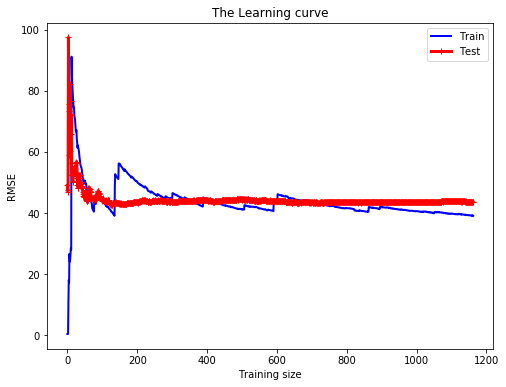

In [11]:
train_errors, test_errors = [], []
for m in range(1, len(df_standardized_train)):
    svr_lin.fit(df_standardized_train[:m], y_train[:m])
    y_train_predict = svr_lin.predict(df_standardized_train[:m])
    y_test_predict = svr_lin.predict(df_standardized_test)
    train_errors.append(sqrt(mean_squared_error(y_train[:m], y_train_predict)))
    test_errors.append(sqrt(mean_squared_error(y_test, y_test_predict)))
    
figure(num=None, figsize=(8,6))    
plt.plot(train_errors, "b-", linewidth=2, label = "Train")
plt.plot(test_errors, "r+-", linewidth=3, label = "Test")
plt.title("The Learning curve")
plt.legend(loc="upper right", fontsize=10) 
plt.xlabel("Training size", fontsize=10)
plt.ylabel("RMSE", fontsize=10)
plt.legend()

#The error in the training size is pretty high and fluctuates a lot with increase in the number of examples
#Ideally we would expect the error to reduce with increase in train set, but the error on test is
#reducing consistently and has steady error after 200 samples

In [12]:
lin_svr = SVR(kernel = 'linear')
lin_svr.fit(df_standardized_train,y_train)
y_train_predict = lin_svr.predict(df_standardized_train)
y_test_predict = lin_svr.predict(df_standardized_test)
train_errors= sqrt(mean_squared_error(y_train, y_train_predict))
test_errors = sqrt(mean_squared_error(y_test, y_test_predict))
print("The training error of the model is ", train_errors)
print("The testing error of the model is ", test_errors)

The training error of the model is  40.46759598986242
The testing error of the model is  40.85395235243734


In [13]:
lin_svr = SVR(C=50,kernel = 'linear',epsilon=0.3,coef0=0.1,gamma='auto')
lin_svr.fit(df_standardized_train,y_train)
y_train_predict = lin_svr.predict(df_standardized_train)
y_test_predict = lin_svr.predict(df_standardized_test)
train_errors= sqrt(mean_squared_error(y_train, y_train_predict))
test_errors = sqrt(mean_squared_error(y_test, y_test_predict))
print("The training error of the model is ", train_errors)
print("The testing error of the model is ", test_errors)

The training error of the model is  39.14097450538682
The testing error of the model is  40.16587593423261


The SVR library has capability to create non-linear hyperplane

    C - Level of Complexity on the error terms
    
    gamma - The extent to which a kernel can be used.
    
    Kernel - This specifies the dimensions to which a data can be projected. It projects and creates a linear line.
    Incase of Non-linear, it can create a hyperplane by projecting data in much higher dimensions

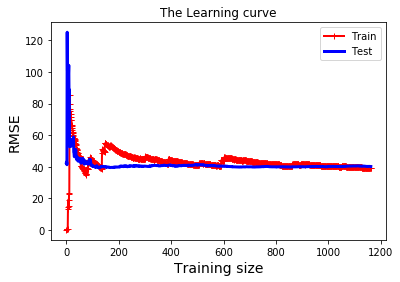

In [14]:
train_errors, test_errors = [], []
for m in range(1, len(df_standardized_train)):
    lin_svr.fit(df_standardized_train[:m], y_train[:m])
    y_train_predict = lin_svr.predict(df_standardized_train[:m])
    y_test_predict = lin_svr.predict(df_standardized_test)
    train_errors.append(sqrt(mean_squared_error(y_train[:m], y_train_predict)))
    test_errors.append(sqrt(mean_squared_error(y_test, y_test_predict)))
    
plt.plot(train_errors, "r+-", linewidth=2, label = "Train")
plt.plot(test_errors, "b-", linewidth=3, label = "Test")
plt.title("The Learning curve")
plt.legend(loc="upper right", fontsize=14) 
plt.xlabel("Training size", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.legend()

In [15]:
test_df = pd.read_csv("dengue_features_test.csv")
test_df.columns = test_df.columns.str.replace(r"reanalysis", "re_an")
test_df.columns = test_df.columns.str.replace(r"humidity", "hd")
test_df.columns = test_df.columns.str.replace(r"precipitation","prec")
test_df = test_df.fillna(method='ffill')

veg_features = ['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']
for i in veg_features:
    test_df[i][test_df[i] <= 0.25] = 0
    test_df[i][test_df[i] > 0.25] = 1
    test_df[i] = test_df[i].astype('category')

In [16]:
X_test_numeric = test_df.drop(columns=['city', 'year','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw',
                                       'week_start_date','weekofyear'])
test_df['year'] = test_df.year.astype('category')
dummy_attributes = test_df[['city', 'year',
                                    'ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']]
# X_test_dummies = pd.get_dummies(dummy_attributes)
X_test_dummies = dummy_attributes.reindex(columns = df_train_dummies.columns, fill_value=0)

test_df_standardized = scaler.fit_transform(X_test_numeric)
test_df_np = np.concatenate([test_df_standardized,np.array(X_test_dummies)],axis=1)

In [17]:
test_y_predict = lin_svr.predict(test_df_np)
submission_df= test_df[["city", "year","weekofyear"]]
submission_df["total_cases"] = test_y_predict
submission_df.to_csv("submission_SVR.csv",index=False)